In [1]:
!pip install --quiet transformers 
!pip install --quiet pytorch-lightning 

In [2]:
import seaborn as sns 
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path

import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv
/kaggle/input/d/nitinteja/news-summary/news_summary.csv
/kaggle/input/stance-data/stance_dataset_modified_02.csv
/kaggle/input/stance-dataset-clean/stance_dataset_modified_3.csv


In [4]:
pl.seed_everything(42)

42

In [6]:
df = pd.read_csv('/kaggle/input/stance-dataset-clean/stance_dataset_modified_3.csv',encoding='latin-1')
df=df.dropna()
df.head()

,prompt,completion
0,quote santa fe shooting implicit support more ...,seriously wtf is wrong with our political syst...
1,quote santa fe shooting explicit denial former...,ma calls bs
2,quote santa fe shooting explicit denial on ave...,on average there is one fake stat about school...
3,quote santa fe shooting comment this week nort...,despite illegal witchunt blah blah blah most s...
4,quote general terms implicit denial i am so co...,one might be made up and not real not sure sti...


In [7]:
train_df, test_df = train_test_split(df, test_size=0.05)
train_df.shape, test_df.shape

((4952, 2), (261, 2))

In [8]:
class StanceDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        completion_max_token_len: int = 128):
        
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.completion_max_token_len = completion_max_token_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["prompt"]
        
        text_encoding = tokenizer(data_row["prompt"],max_length=self.text_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        completion = data_row["completion"]
        completion_encoding = tokenizer(completion,max_length=self.completion_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        labels= completion_encoding["input_ids"] 
        labels[labels == 0] = -100
        
        return dict(
            text=text, 
            completion=completion,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=completion_encoding["attention_mask"].flatten())
            

In [9]:
class StanceDatasetModule(pl.LightningDataModule):
    def __init__(self, 
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 8,
                text_max_token_len: int = 512,
                completion_max_token_len: int = 128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.completion_max_token_len= completion_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset =  StanceDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.completion_max_token_len
        )
        self.test_dataset =  StanceDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.completion_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)

In [10]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

In [11]:
text_token_counts, completion_token_counts = [],[]
for _, row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row['prompt']))
    text_token_counts.append(text_token_count)
    
    completion_token_count=len(tokenizer.encode(row['completion']))
    completion_token_counts.append(completion_token_count)

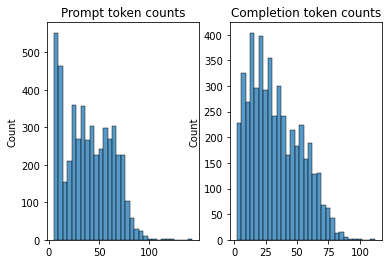

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Prompt token counts")

sns.histplot(completion_token_counts,ax=ax2)
ax2.set_title("Completion token counts")

fig.show()


In [13]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = StanceDatasetModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

# Model

In [14]:
class StanceDatasetModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits
    
    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs
    
    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        
        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [15]:
model = StanceDatasetModel()

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [16]:
!kill 2079
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: line 0: kill: (2079) - No such process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
checkpoint_callback = ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best-checkpoint",
                        save_top_k=1,
                        verbose=True, 
                        monitor="val_loss",
                        mode="min")
logger = TensorBoardLogger("lightning_logs", name="prompt-completion")

from pytorch_lightning.callbacks.progress import ProgressBar
class LitProgressBar(ProgressBar):

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate=30
        return bar

bar = LitProgressBar()

trainer = pl.Trainer(logger=logger,
                    enable_checkpointing=checkpoint_callback,
                    max_epochs=N_EPOCHS,
                    gpus=1,
                    progress_bar_refresh_rate=30)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/progress/progress.py:24: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"


In [18]:
trainer.fit(model,data_module)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
trained_model = StanceDatasetModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
    )

In [20]:
def get_response(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True)
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    return "".join(preds)
    

In [38]:
sample_row = train_df.iloc[190]
text = sample_row["prompt"]
ref_completion = sample_row["completion"]

model_completion = get_response(text)

print('Target text :  \n', text)
print('\nPredicted Response Text :  \n', model_completion)
print('\nOriginal Response Text :  \n', ref_completion)

Target text :  
 quote general terms explicit support this is huge bombshell forensic analysis shows clinton emails except of over k were funneled to a foreign entity unrelated to russia the obama fbi doj cia amp nsa did nothing clinton is guilty as sin

Predicted Response Text :  
 obama is a liar

Original Response Text :  
 america no longer trusts the fbi hillary destroyed information while under investigation which is the definition of obstruction of justice yet no prosecution fake trump dossier starts deep state investigation no trust real donald trump
